**Initialization**

In [1]:
import numpy as np

import datetime as dt

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

# **Task 1: Data set**

The Cifar10 dataset comes directly in a two-part dataset for training and test data. The training dataset contains 50000 image-label pairs and the test dataset 10000 image-label pairs. The labels are displayed as numbers from 0 to 9. Among other things in the following code snippet these numbers are mapped to their string label class names. The images in the datasets come up with a fixed shape of 32 x 32 x 3. Thus no resizing is necessary. 

Additionally, some example images of the dataset are displayed with the corresponding string label class name.

170500096/170498071 [==============================] - 2s 0us/step
Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


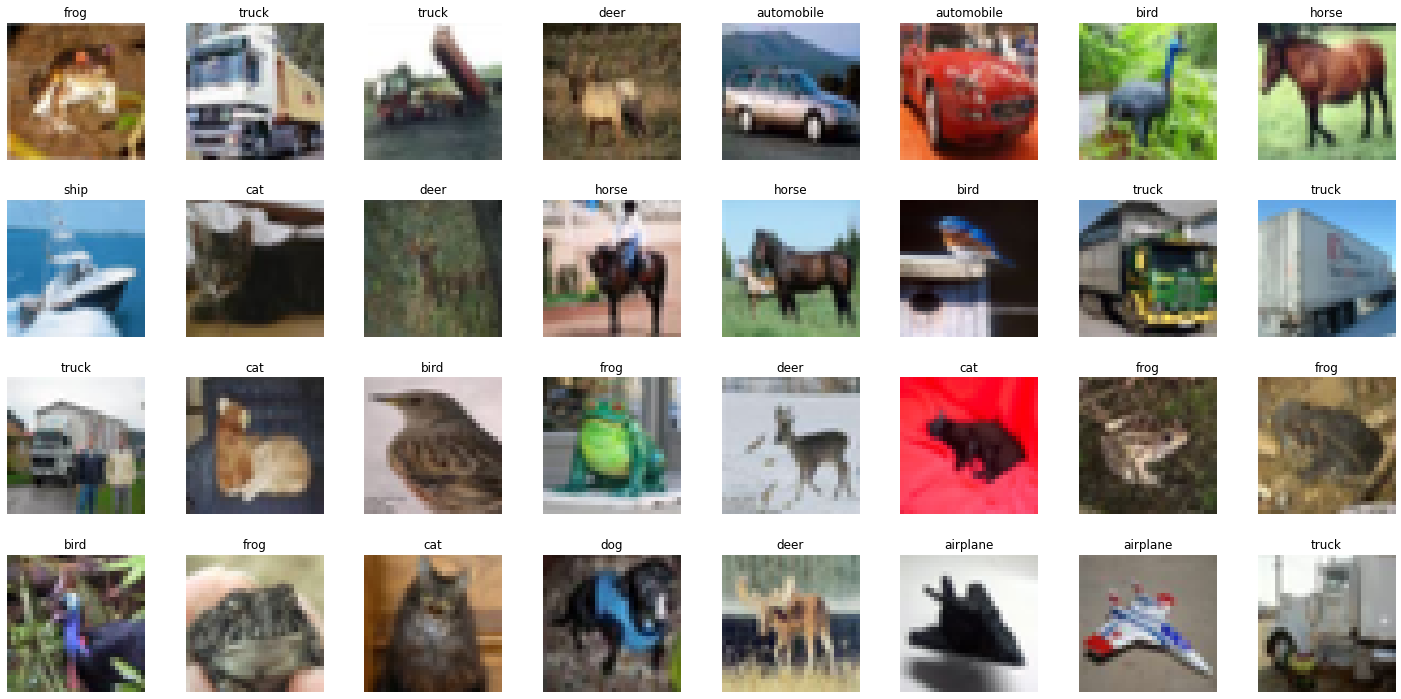

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline

In [3]:
batch_size = 128

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

# **Task 2.2: Model - DenseNet**

**Class TransitionLayer**

Implementation of a callable Transition Layer for the DenseNet. 

This one should include:

*   Concolutional Layer
*   Batch Normalization
*   Activation Function ReLu
*   Pooling Layer (AveragePooling)













In [4]:
# Description: The class TransitionLayer describes a transition layer of a DenseNet.
class TransitionLayer(tf.keras.layers.Layer): 
  
  def __init__(self, num_channels_trans_layer):
    super(TransitionLayer, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = num_channels_trans_layer,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
    self.activ_1 = tf.keras.activations.relu                         
    self.aver_pool_1 = tf.keras.layers.AveragePooling2D(strides=(2, 2), padding = 'same')   #Without strides?

  # Description: This function conducts one forward-step of the transition layer. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.aver_pool_1(x)
    return x

**Class ConvolutionalBlock**

This class is needed to create a Dense Block. It includes one convolutional layer. When calling, the forward step is conducted and the output of the layer is concatenate with the input itself. The result of the concatenation is the output of the convolutional block.

In [5]:
# Description: The class ConvolutionalBlock describes a convolutional block of a DenseBlock.
class ConvolutionalBlock(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(ConvolutionalBlock, self).__init__()

    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu                
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.conv_2 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_2 = tf.keras.activations.relu          
    self.concat = tf.keras.layers.Concatenate()               

  # Description: This function conducts one forward-step of the convolutional block. Therefore the block output
  #              is concatenated with the block input. The python decorator @tf.function is used to bundle multiple 
  #              computations into one computational graph.
  #              @parameters: block_input, training (to differ between training and test calls of the residual block)
  #              @returns: block_output
  @tf.function
  def call(self, block_input, training = True):
    x = self.batch_norm_1(block_input, training)
    x = self.activ_1(x)
    x = self.conv_1(x)
    x = self.conv_2(x) 
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)

    block_output = self.concat([x, block_input]) 
    return block_output

**Class DenseBlock**

Implementation of the Dense Blocks for the DenseNet. They include as many convolutional blocks as the init parameter num_conv_blocks defines. The total number of convolutional layers of the Dense Block is num_conv_blocks.

In [6]:
# Description: The class DenseBlock describes a dense block of a DenseNet.
class DenseBlock(tf.keras.layers.Layer): 

  def __init__(self, num_conv_blocks):
    super(DenseBlock, self).__init__()

    self.convolutional_blocks = []
    for _ in range(num_conv_blocks):
      self.convolutional_blocks.append(ConvolutionalBlock())

  # Description: This function conducts one forward-step of the dense block. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (output) x
  @tf.function
  def call(self, x, training = True):
    for conv_block in self.convolutional_blocks:
      x = conv_block(x, training)
    return x

**Class DenseNet**

In [7]:
# The class DenseNet describes a dense convolutional neural network with a feature extractor and a classifier.
class DenseNet(tf.keras.Model): 
  
  def __init__(self, num_dense_blocks, num_conv_blocks, growth_rate):
    super(DenseNet, self).__init__()

    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (32, 32, 3))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
    self.activ_1 = tf.keras.activations.relu   

    num_channels_trans_layer = growth_rate * num_conv_blocks
    self.dense_blocks_and_trans_layers = []
    for _ in range(num_dense_blocks - 1):                         # The last dense block does not need a transition layer -> num_dense_blocks - 1 
      self.dense_blocks_and_trans_layers.append(DenseBlock(num_conv_blocks))   
      self.dense_blocks_and_trans_layers.append(TransitionLayer(num_channels_trans_layer)) 
    self.last_dense_block = DenseBlock(num_conv_blocks)

    # Classifier
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout = tf.keras.layers.Dropout(rate = 0.5)                                               # (5)    
    self.output_layer = tf.keras.layers.Dense(10, 
                                              activation=tf.keras.activations.softmax)#,
                                              #kernel_initializer = tf.keras.initializers.glorot_normal,   
                                              #bias_initializer = 'zeros',                                 
                                              #kernel_regularizer = tf.keras.regularizers.L2(0.01))

  # Description: This function conducts one forward-step of the Dense CNN. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)

    for i in self.dense_blocks_and_trans_layers:
      x = i(x, training)
    x = self.last_dense_block(x, training)

    x = self.global_pool(x)
    x = self.dropout(x)
    x = self.output_layer(x)
    return x

# **Task 3: Training and Analysis**

In [8]:
# Description: This function conducts a forward-step and the backpropagation of a CNN. It does not matter whether the CNN is a ResNet or 
#              a DenseNet (this is defined by the parameter model). Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training (to differ between training and test calls of the CNN)
#              @returns: training_loss, training_accuracy
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction)+ tf.math.reduce_sum(model.losses)   # (3)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of a CNN. It does not matter 
#              whether the CNN is a ResNet or a DenseNet (this is defined by the parameter model).
#              @parameters: model, test_data, loss_fn, training (to differ between training and test calls of the CNN)
#              @returns: test_loss, test_accuracy
#@tf.function
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0
2020-12-07 20:45:39.745119
Training accuracy: 0.4356697570332481
Test accuracy: 0.10571598101265822
Epoch 1
2020-12-07 20:46:36.496871
Training accuracy: 0.5775455562659847
Test accuracy: 0.314873417721519
Epoch 2
2020-12-07 20:47:19.905217
Training accuracy: 0.6219789002557544
Test accuracy: 0.5357001582278481
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transition multiple                  23940     
_________________________________________________________________


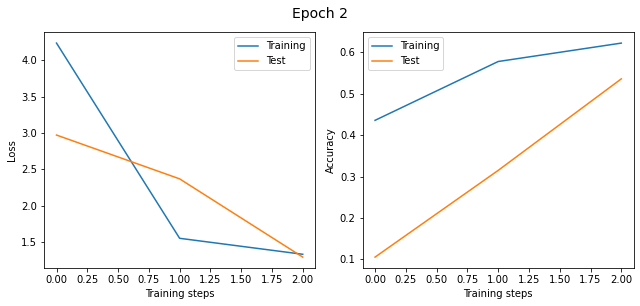

Epoch 3
2020-12-07 20:48:03.884136
Training accuracy: 0.650087915601023
Test accuracy: 0.4624208860759494
Epoch 4
2020-12-07 20:48:47.803512
Training accuracy: 0.6679467710997443
Test accuracy: 0.5665545886075949
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transition multiple                  23940     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  51120     
__________________________________________

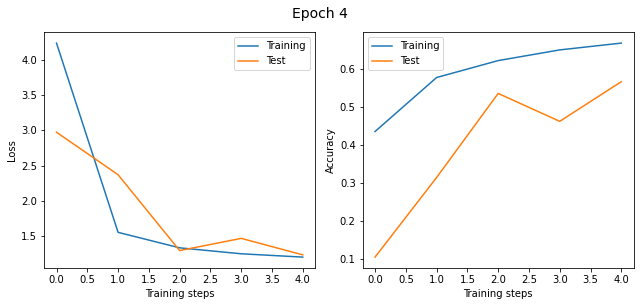

Epoch 5
2020-12-07 20:49:32.182527
Training accuracy: 0.6895740089514067
Test accuracy: 0.46044303797468356
Epoch 6
2020-12-07 20:50:15.795236
Training accuracy: 0.7002837276214834
Test accuracy: 0.6038370253164557
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transition multiple                  23940     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  51120     
________________________________________

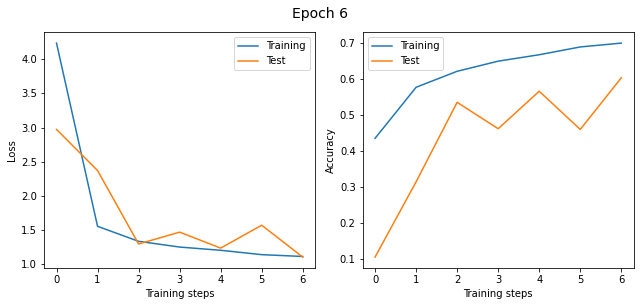

Epoch 7
2020-12-07 20:50:59.749881
Training accuracy: 0.7138107416879796
Test accuracy: 0.6037381329113924
Epoch 8
2020-12-07 20:51:43.206647
Training accuracy: 0.7250679347826087
Test accuracy: 0.5502373417721519
Epoch 9
2020-12-07 20:52:26.894489
Training accuracy: 0.7320971867007673
Test accuracy: 0.5330300632911392
Epoch 10
2020-12-07 20:53:10.158829
Training accuracy: 0.7451366687979539
Test accuracy: 0.5511273734177216
Epoch 11
2020-12-07 20:53:53.357202
Training accuracy: 0.7519741048593351
Test accuracy: 0.598496835443038
Epoch 12
2020-12-07 20:54:36.795111
Training accuracy: 0.7580562659846547
Test accuracy: 0.6422072784810127
Epoch 13
2020-12-07 20:55:19.703651
Training accuracy: 0.7606697570332481
Test accuracy: 0.456190664556962
Epoch 14
2020-12-07 20:56:02.620392
Training accuracy: 0.7675311700767263
Test accuracy: 0.5427215189873418
Epoch 15
2020-12-07 20:56:45.456318
Training accuracy: 0.7686940537084399
Test accuracy: 0.5625988924050633
Epoch 16
2020-12-07 20:57:28.2632

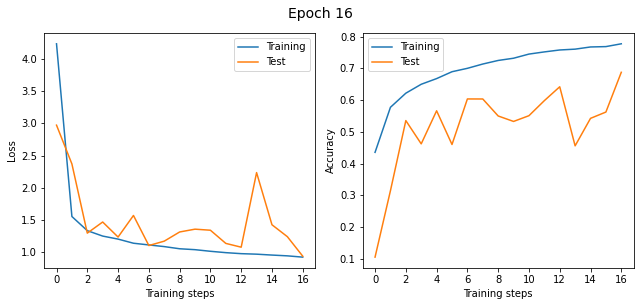

Epoch 17
2020-12-07 20:58:11.404212
Training accuracy: 0.7792039641943733
Test accuracy: 0.6438884493670886
Epoch 18
2020-12-07 20:58:54.265095
Training accuracy: 0.7830442774936062
Test accuracy: 0.534315664556962
Epoch 19
2020-12-07 20:59:37.180176
Training accuracy: 0.7849024936061382
Test accuracy: 0.5960245253164557
Epoch 20
2020-12-07 21:00:19.789951
Training accuracy: 0.7885709718670078
Test accuracy: 0.6319224683544303
Epoch 21
2020-12-07 21:01:02.344641
Training accuracy: 0.7913003516624041
Test accuracy: 0.6790941455696202
Epoch 22
2020-12-07 21:01:44.959800
Training accuracy: 0.7915361253196932
Test accuracy: 0.6421083860759493
Epoch 23
2020-12-07 21:02:27.564419
Training accuracy: 0.7955362851662404
Test accuracy: 0.6610957278481012
Epoch 24
2020-12-07 21:03:10.074388
Training accuracy: 0.7994645140664961
Test accuracy: 0.7077729430379747
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape           

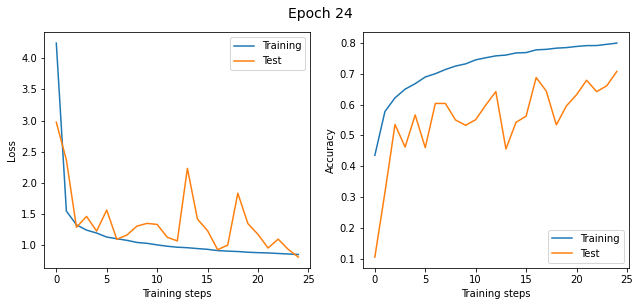

Epoch 25
2020-12-07 21:03:53.116895
Training accuracy: 0.7984335038363172
Test accuracy: 0.7267602848101266
Epoch 26
2020-12-07 21:04:35.881326
Training accuracy: 0.8001278772378517
Test accuracy: 0.5543908227848101
Epoch 27
2020-12-07 21:05:18.500182
Training accuracy: 0.803716432225064
Test accuracy: 0.594442246835443
Epoch 28
2020-12-07 21:06:01.098239
Training accuracy: 0.805662563938619
Test accuracy: 0.7538568037974683
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  35136     
_________________________________________________________________
transition_layer (Transi

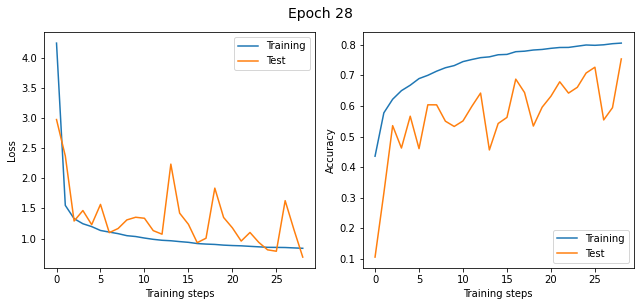

Epoch 29
2020-12-07 21:06:44.033205
Training accuracy: 0.806781489769821
Test accuracy: 0.6212420886075949
Epoch 30
2020-12-07 21:07:26.533029
Training accuracy: 0.8080003196930947
Test accuracy: 0.6057159810126582
Epoch 31
2020-12-07 21:08:09.082161
Training accuracy: 0.809874520460358
Test accuracy: 0.7101463607594937
Epoch 32
2020-12-07 21:08:51.582893
Training accuracy: 0.8110653772378517
Test accuracy: 0.6659414556962026
Epoch 33
2020-12-07 21:09:34.087240
Training accuracy: 0.8123761189258313
Test accuracy: 0.706190664556962
Epoch 34
2020-12-07 21:10:16.914025
Training accuracy: 0.8138027493606137
Test accuracy: 0.6661392405063291
Epoch 35
2020-12-07 21:10:59.338868


In [ ]:
# Description: This part creates objects of a ResNet and DenseNet and executes the training and testing of these models in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

num_dense_blocks = 3
num_conv_blocks = 3 
growth_rate = 60
model = DenseNet(num_dense_blocks, num_conv_blocks, growth_rate)   

n_epochs = 40
learning_rate = 0.001
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5                                    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))
    ts_now = dt.datetime.now()
    print(ts_now)

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print("Training accuracy: " + str(training_accuracy))
    print("Test accuracy: " + str(test_accuracy))

    # Visualization during training to check how the CNN is doing. In 5% steps of the test accuracy starting up from 50% test accuracy.
    if test_accuracy >= dynamic_threshold_train_visio: 
      model.summary()  #!!!find a different place for this!!!

      fig, ax = plt.subplots(1,2, figsize=(9, 4))

      fig.suptitle(('Epoch ' + str(epoch)), fontsize=14, y=1.05)
      line1, = ax[0].plot(training_losses)
      line2, = ax[0].plot(test_losses)
      ax[0].set_xlabel("Training steps")
      ax[0].set_ylabel("Loss")
      ax[0].legend((line1, line2),("Training", "Test"))

      line1, = ax[1].plot(training_accuracies)
      line2, = ax[1].plot(test_accuracies)
      ax[1].set_xlabel("Training steps")
      ax[1].set_ylabel("Accuracy")
      ax[1].legend((line1, line2),("Training", "Test"))

      fig.tight_layout()
      plt.draw()
      plt.show()

      # Increases the test accuracy threshold by 5%.  
      dynamic_threshold_train_visio += 0.05

# **Visualization**

In [ ]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()